In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import csv
from PIL import Image
import shutil
from tqdm import tqdm
import torch
# ssim
from skimage.metrics import structural_similarity as ssim

from utils.utils0 import tensor_affine_transform, transform_to_displacement_field
from utils.utils1 import transform_points_DVF, ModelParams
from utils.SuperPoint import SuperPointFrontend, PointTracker
from utils.datagen import datagen

nn_thresh = 0.7
superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=nn_thresh, cuda=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data
data = pd.read_csv('Dataset/dataset_eye_actual_full.csv')


Device: cuda


In [2]:
# take data with 'training' = 0
# data = data[data['training'] == 0].reset_index(drop=True)

In [3]:
data.head()

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory
0,0,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
1,1,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
2,2,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
3,3,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc
4,4,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc


In [4]:
data.shape

(5040, 10)

In [5]:
# add columns 'keypoints', 'mse', 'tre'
data['keypoints'] = 0
data['no_keypoints'] = 0
data['mse'] = 0
data['ssim'] = 0
data['tre'] = 0
# keypoints_path = []

# calculate the keypoints, mse, tre
for i in range(data.shape[0]):
    # keypoints = 0
    # mse = 0
    # tre = 0
    # read image file from column 'source' and 'target'
    source = cv2.imread(data['source'].iloc[i], 0)
    target = cv2.imread(data['target'].iloc[i], 0)
    source = cv2.resize(source, (256, 256), interpolation=cv2.INTER_AREA)
    target = cv2.resize(target, (256, 256), interpolation=cv2.INTER_AREA)
    source = (source / np.max(source)).astype(np.float32)
    target = (target / np.max(target)).astype(np.float32)

    points1, desc1, heatmap1 = superpoint(source)
    points2, desc2, heatmap2 = superpoint(target)

    tracker = PointTracker(5, nn_thresh=0.7)
    try:
        matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=nn_thresh)
    except:
        print('No matches found')
        # TODO: find a better way to do this
        pass

    matches1 = np.array(points1[:2, matches[0, :].astype(int)])
    matches2 = np.array(points2[:2, matches[1, :].astype(int)])

    df = pd.DataFrame({'x1': matches1[0, :], 'y1': matches1[1, :],
                       'x2': matches2[0, :], 'y2': matches2[1, :]})
    save_name = 'Dataset/eye_keypoints_all/' + f'img_{i}.csv'

    df.to_csv(save_name, index=False)

    # calculate MSE
    mse = np.mean((source - target) ** 2)
    # calculate ssim
    ssim_ = ssim(source, target, data_range=target.max() - target.min())
    # calculate TRE
    tre = np.sqrt(np.sum((matches1 - matches2) ** 2))

    # save keypoints, mse, tre to the dataframe
    data['keypoints'][i] = save_name
    data['no_keypoints'][i] = matches1.shape[1]
    data['ssim'][i] = ssim_
    data['mse'][i] = mse
    data['tre'][i] = tre

data.head()
# print(data.shape)

/tmp/ipykernel_169757/958484947.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['keypoints'][i] = save_name
/tmp/ipykernel_169757/958484947.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Dataset/eye_keypoints_all/img_0.csv' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['keypoints'][i] = save_name
/tmp/ipykernel_169757/958484947.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['no_keypoints'][i] = matches1.shape[1]
/tmp/ipykernel_169757/958484947.py:52: SettingWithCopyWarning: 

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,0,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_0.csv,108,0.005946,0.673900,38.301436
1,1,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_1.csv,100,0.039183,0.315230,230.514642
2,2,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_2.csv,87,0.039406,0.310896,209.511336
3,3,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/eye_keypoints_all/img_3.csv,99,0.013952,0.467387,79.277992
4,4,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/eye_keypoints_all/img_4.csv,96,0.014507,0.462670,84.498521


In [6]:
# save the dataframe to csv
# data.to_csv('dataset_eye.csv', index=False)

In [7]:
data.shape

(5040, 15)

In [8]:
mse = data['mse']
tre = data['tre']
kp = data['no_keypoints']
ssim_ = data['ssim']

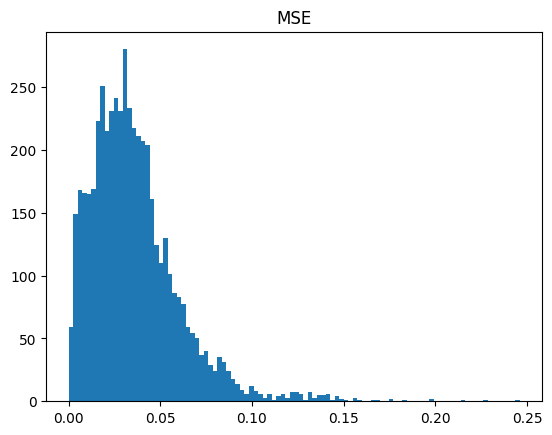

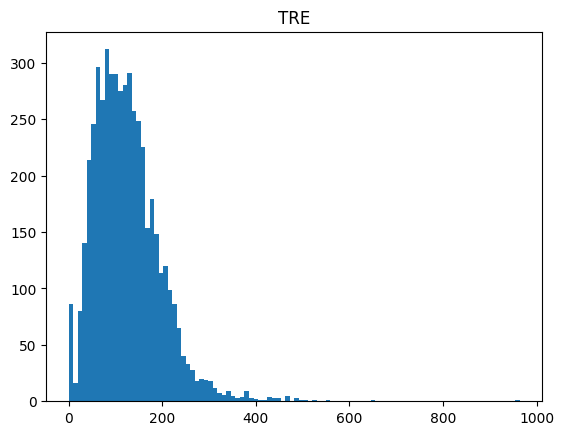

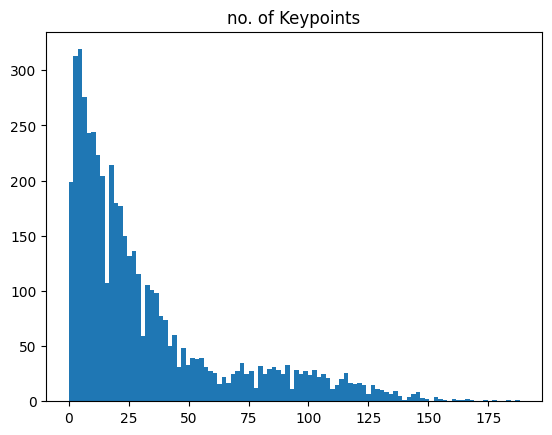

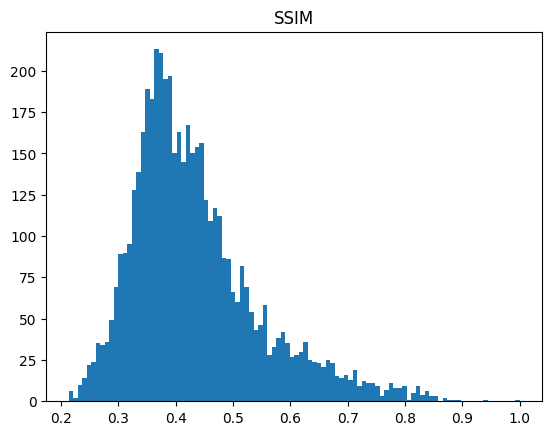

In [9]:
plt.hist(mse, bins=100)
plt.title('MSE')
plt.show()

plt.hist(tre, bins=100)
plt.title('TRE')
plt.show()

plt.hist(kp, bins=100)
plt.title('no. of Keypoints')
plt.show()

plt.hist(ssim_, bins=100)
plt.title('SSIM')
plt.show()

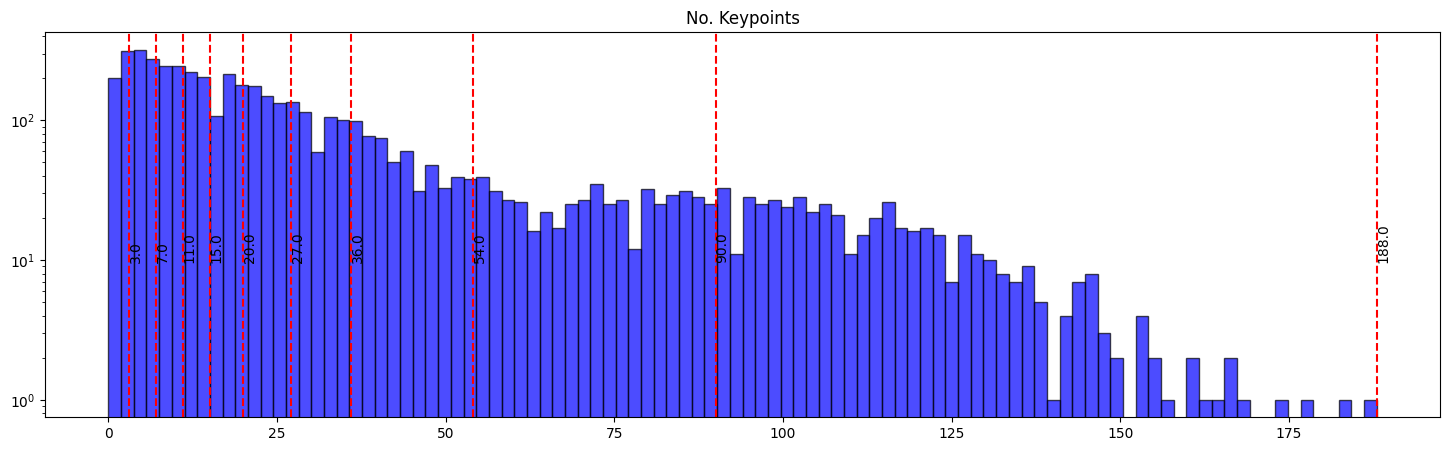

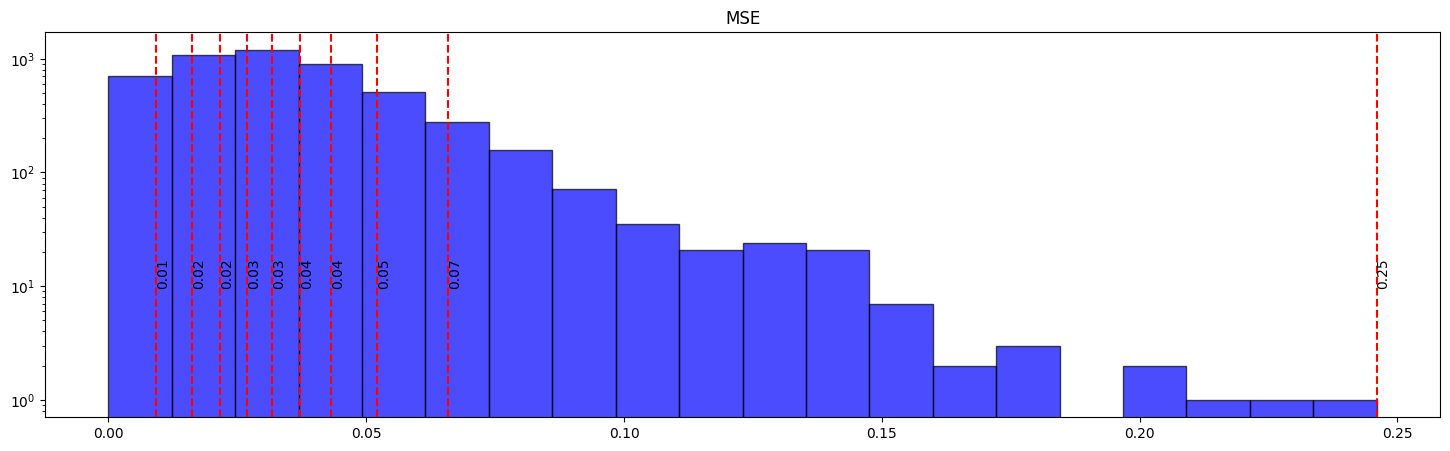

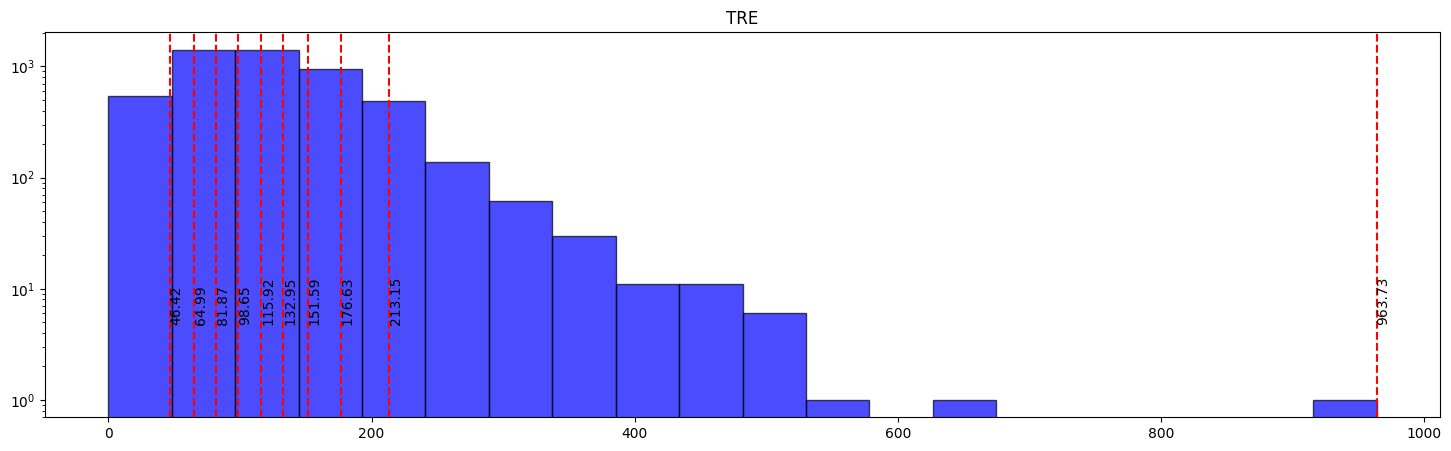

In [10]:
# show histogram with different colors for each 10% of mse, tre

kp_10 = np.percentile(kp, np.arange(0, 101, 10))
mse_10 = np.percentile(mse, np.arange(0, 101, 10))
tre_10 = np.percentile(tre, np.arange(0, 101, 10))

plt.figure(figsize=(18, 5))
plt.hist(kp, bins=100, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(kp_10)):
    plt.axvline(kp_10[i], color='red', linestyle='dashed')
    plt.text(kp_10[i], 10, str(kp_10[i]), rotation=90)
plt.title('No. Keypoints')
plt.yscale('log')
plt.show()

# show histogram with different colors for each 10% of mse, tre
plt.figure(figsize=(18, 5))
plt.hist(mse, bins=20, color='blue', alpha=0.7, edgecolor='black')

for i in range(1, len(mse_10)):
    plt.axvline(mse_10[i], color='red', linestyle='dashed')
    plt.text(mse_10[i], 10, str(round(mse_10[i], 2)), rotation=90)
plt.title('MSE')
plt.yscale('log')
plt.show()

plt.figure(figsize=(18, 5))
plt.hist(tre, bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(tre_10)):
    plt.axvline(tre_10[i], color='red', linestyle='dashed')
    plt.text(tre_10[i], 5, str(round(tre_10[i], 2)), rotation=90)
plt.yscale('log')
plt.title('TRE')
plt.show()


In [11]:
# sort data by 'mse' and reset index
# data = data.sort_values(by='mse').reset_index(drop=True)
data

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,0,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_0.csv,108,0.005946,0.673900,38.301436
1,1,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_1.csv,100,0.039183,0.315230,230.514642
2,2,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb,Dataset/eye_keypoints_all/img_2.csv,87,0.039406,0.310896,209.511336
3,3,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/eye_keypoints_all/img_3.csv,99,0.013952,0.467387,79.277992
4,4,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/eye_keypoints_all/img_4.csv,96,0.014507,0.462670,84.498521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,5035,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,Dataset/eye_keypoints_all/img_5035.csv,11,0.060581,0.407158,119.226675
5036,5036,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,Dataset/eye_keypoints_all/img_5036.csv,45,0.038439,0.562149,348.559894
5037,5037,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,Dataset/eye_keypoints_all/img_5037.csv,15,0.063314,0.402427,142.207595
5038,5038,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,Dataset/eye_keypoints_all/img_5038.csv,37,0.041813,0.561278,343.129713


# sort image pair difficulty by number of matched keypoint pairs

In [12]:
# sort kp from smallest to largest
data = data.sort_values(by='no_keypoints').reset_index(drop=True)
# delete the column Unnamed: 0
data = data.drop(columns='Unnamed: 0')
data

,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,Dataset/Dataset-processed/28-04-2560/3792354-L...,NaN,Dataset/Dataset-processed/28-04-2560/3792354-L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3792354-L/c,Dataset/eye_keypoints_all/img_4776.csv,0,0.076292,0.317088,0.000000
1,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/2238864-R...,Dataset/eye_keypoints_all/img_4894.csv,0,0.140819,0.443707,0.000000
2,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R/c,Dataset/eye_keypoints_all/img_4362.csv,0,0.086547,0.310896,0.000000
3,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R/c,Dataset/eye_keypoints_all/img_4366.csv,0,0.093404,0.263288,0.000000
4,Dataset/Dataset-processed/28-04-2560/3792354-L...,NaN,Dataset/Dataset-processed/28-04-2560/3792354-L...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3792354-L/c,Dataset/eye_keypoints_all/img_4780.csv,0,0.081432,0.388608,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b1,Dataset/eye_keypoints_all/img_1022.csv,169,0.004428,0.586307,72.587878
5036,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b1,Dataset/eye_keypoints_all/img_1015.csv,173,0.006718,0.563710,101.548018
5037,Dataset/Dataset-processed/31-03-2560/0956143-R...,NaN,Dataset/Dataset-processed/31-03-2560/0956143-R...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/31-03-2560/0956143-R/b,Dataset/eye_keypoints_all/img_3574.csv,178,0.006364,0.537737,43.011626
5038,Dataset/Dataset-processed/20-01-2560/3755654/c...,NaN,Dataset/Dataset-processed/20-01-2560/3755654/c...,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/20-01-2560/3755654/c,Dataset/eye_keypoints_all/img_3439.csv,183,0.004922,0.663326,38.288379


In [17]:
# change all training to 0
data['training'] = 0

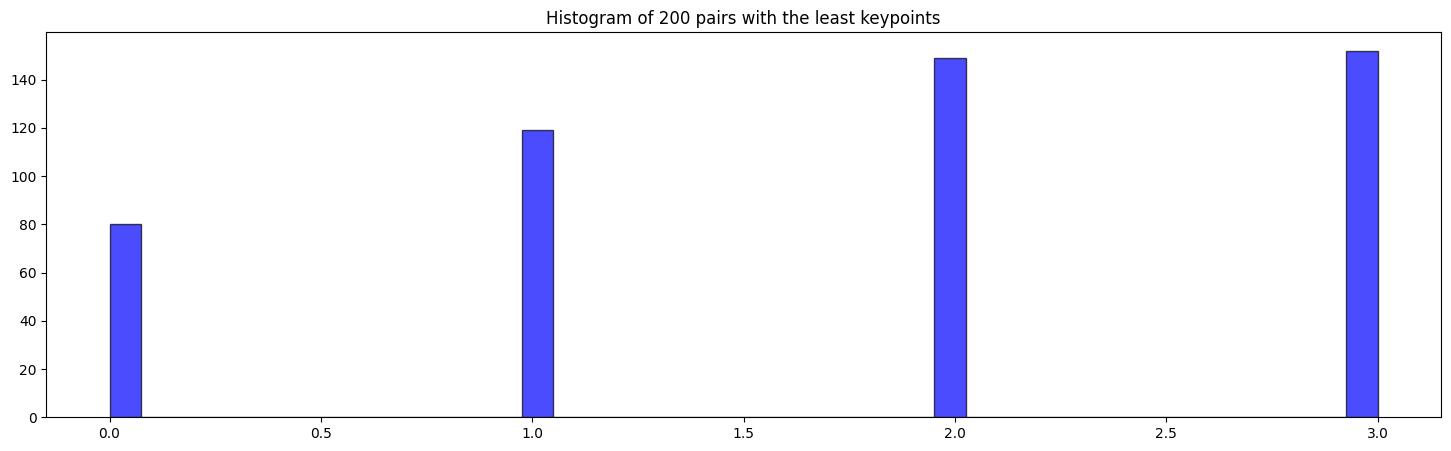

In [13]:
# histogram of 200 pairs with the least keypoints
plt.figure(figsize=(18, 5))
plt.hist(data['no_keypoints'][:500], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of 200 pairs with the least keypoints')
plt.show()

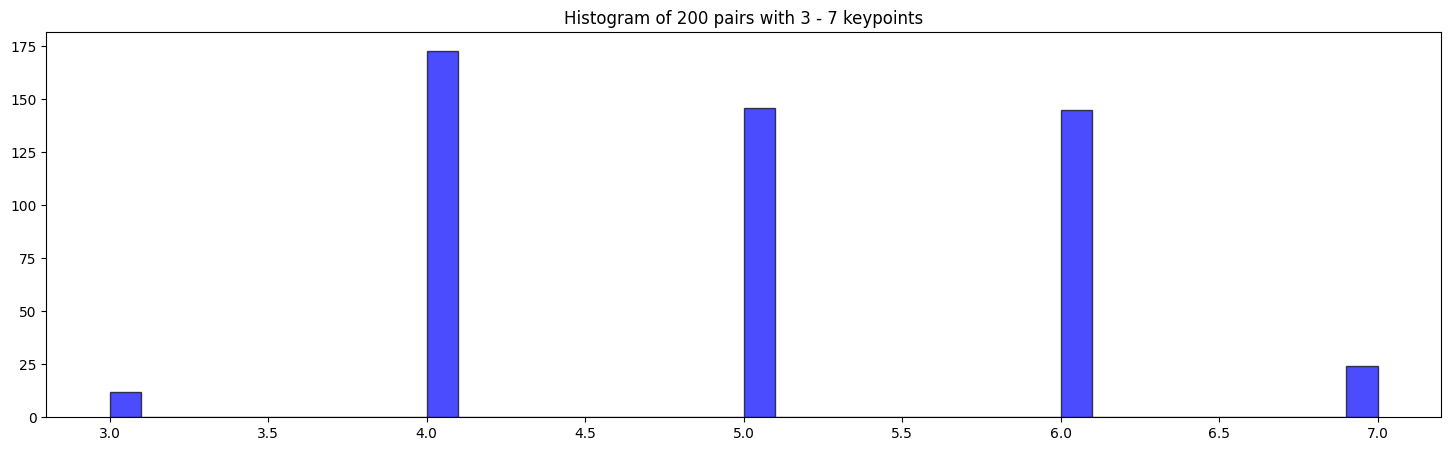

In [14]:
# histogram of 200 pairs with 201-400 keypoints
plt.figure(figsize=(18, 5))
start = 500
stop = 1000
plt.hist(data['no_keypoints'][start:stop], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of 200 pairs with {data['no_keypoints'][start]} - {data['no_keypoints'][stop]} keypoints")
plt.show()

Text(0.5, 1.0, 'Histogram of 200 pairs with 7 - 11 keypoints')

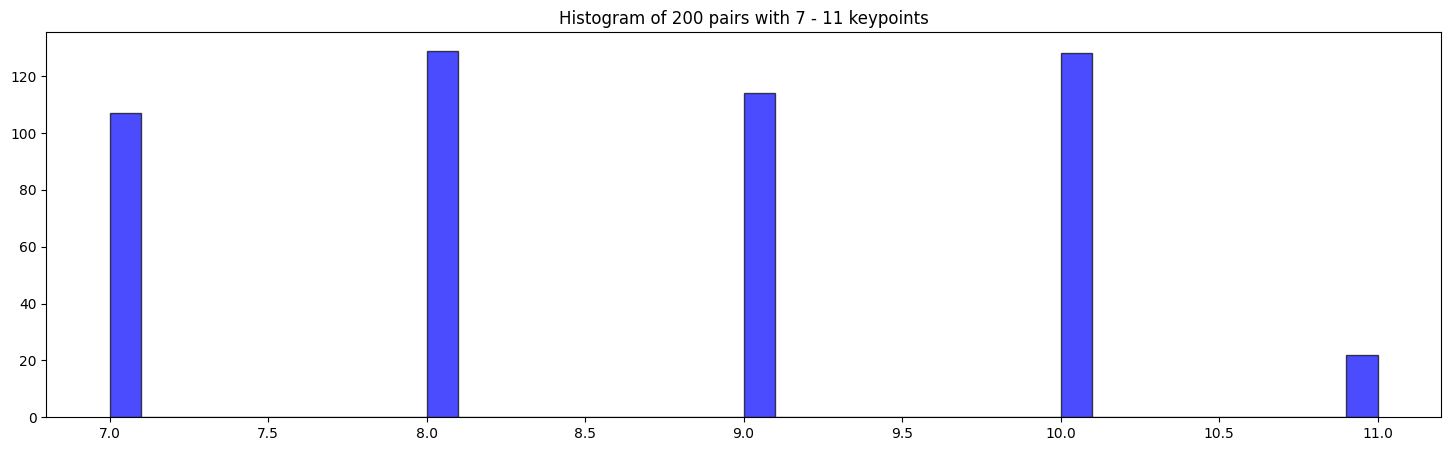

In [15]:
# histogram of 200 pairs with the most keypoints
plt.figure(figsize=(18, 5))
start = 1000
stop = 1500
plt.hist(data['no_keypoints'][start:stop], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of 200 pairs with {data['no_keypoints'][start]} - {data['no_keypoints'][stop]} keypoints")

In [19]:
# # save the dataframe to csv
# # row 0 - 346: very hard dataset
data[:348].to_csv('Dataset/dataset_eye_11.csv', index=False)

# row 347 - 500: hard dataset
data[348:500].to_csv('Dataset/dataset_eye_10.csv', index=False)

# # row 201 - 400: medium dataset
# data[201:400].to_csv('Dataset/dataset_eye_medium.csv', index=False)

# # row 401 - end: easy dataset
# data[401:].to_csv('Dataset/dataset_eye_easy.csv', index=False)